로밍등록자수 정보의 Numeric timeseries data와 뉴스정보의 Unstructured text data를 혼합하여 향후 15일간의 입국자수를 예측한다.
이하 분석 방법과 알고리즘은 이번 코로나 상황에서 우리나라 입국자 수를 예측하는데 뿐만아니라 일반화 하여 뉴스 정보를 포함한 각종 시계열 정보를 예측하는데도 효과적으로 사용 될 수 있을 것으로 기대한다.


<b>1. Forecast with numeric timeseries data</b>
   <br>로밍등록자 시계열 data와 뉴스에서 BERT embedding기반 6개의 주요 feature를 추출한 시계열 data를 혼합하여 1D Convolution에 의한 regression으로 입국자를 추정한다.

<b>2. Forecast with unstructured text timeseries data (제출 내용 아님)</b>
   <br>News의 BERT embedding 전체를 1D Convolution에 의한 regression으로 입국자를 추정한다.정성적 data를 통해 정량적 data를 예측하는 것은 모순이 있으나, "3. Forecast with combined numeric timeseries and unstructured timeseries data"을 위한 예비 Test로서 시행해 본다.

<b>3. Forecast with combined numeric timeseries and unstructured timeseries data (제출 내용 아님)</b>
   <br>마지막으로 로밍등록자 시계열 data와 News의 BERT embedding 전체 시계열 data를 합친 Multi input, Mixed data 1D+2D Convolution model에 의해 입국자를 추정한다.


 1. Forecast with numeric timeseries data<br>
	1.1 Roaming Data의 전처리 및 분석
 		1.1.1 Roaming Data의 load
 		1.1.2 Roaming Data에 대한 EDA
 			1.1.2.1 도착일을 기준으로 입국자(로밍등록자)의 합산
 			1.1.2.2 입국자(로밍등록자) 추세 chart 확인
 		1.1.3 Roaming Data의 전처리
 			1.1.3.1 iso 별로 재배열
 			1.1.3.2 2주 (14일) 평균 추세 추가.
 			1.1.3.3 Trainingset의 구성
 		1.1.4 CNN model 구성 
 		1.1.5 model training
 			1.1.5.1 model training
 			1.1.5.2 trainset에 의한 입국자(로밍등록자) 예측 역산 
 			1.1.5.3 과거 Data에서 실등록자 count와 예측 count의 비교 
 		1.1.6  향후 15일 예측
 			1.1.6.1 testset (마지막 30일)의 inference
 			1.1.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출
 	1.2 News Data의 전처리
		1.2.1 News Data load
 		1.2.2 News Data에 대한 EDA
 			1.2.2.1 게시일을 기준으로 News buzz의 합산
 			1.2.2.2 하루 최대 buzz count 추출
 			1.2.2.3 News buzz 추세 Chart
 		1.2.3 News Data의 전처리
 			1.2.3.1 BERT embedding 준비
 			1.2.3.2 News의 BERT embedding
 			1.2.3.3 News data의 feature 추출 (차원 축소)
			1.2.3.4 News feature의 Normalization
			1.2.3.5 Outlier 제거
			1.2.3.6 Scale 보정
	1.3 Roaming Data와 News Data의 통합 Dataset 구성
	1.4 통합 Dataset 의 전처리
		1.4.1 시계열 분석을 위한 slidng window적용 Trainset의 구성
	1.5 통합 CNN Model 구성
	1.6 통합 CNN 학습
		1.6.1 model training
 		1.6.2 trainset에 의한 입국자(로밍등록자) 예측 역산 
 	1.7 통합 향후 15일 예측
 		1.7.1 testset (마지막 30일)의 inference
 		1.7.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출
	1.8 ensemble에 의한 15일 예측
		1.8.1 train 100회 시행
		1.8.2 trainset에 의한 입국자(로밍등록자) 예측 역산 
		1.8.3 testset (마지막 30일)의 inference
		1.8.3 신뢰수준 95%에서 입국자 예측 결과  

In [0]:
# 분석에 필요한 많이 쓰는 함수 미리 정의

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.models import model_from_json

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def plot_train_result(hist):
    """
    학습의 결과, epoch 당 mean_absolute_error, R square, accuracy 등의 값을 Chart로 나타낸다.
    :param hist: hist = model.fit(....)
    :return:
    """
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    if 'mae' in hist.history:
        color = 'tab:red'
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('mean absolute error',color=color)
        plt.plot(hist.history['mae'],color=color)
        ax1.tick_params(axis='y', labelcolor=color)

    if 'r2' in hist.history:
        color = 'tab:blue'
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('R square',color=color)
        plt.plot(hist.history['r2'],color=color)
        ax2.tick_params(axis='y', labelcolor=color)

    if 'acc' in hist.history:
        color = 'tab:blue'
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('accuracy',color=color)
        plt.plot(hist.history['acc'],color=color)
        ax2.tick_params(axis='y', labelcolor=color)
    plt.title('Train history')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


def compare_with_org_y(org_y=None, comp_y=None, comp_index=[0, 14], window=30, forecast=15, title='Forecast result'):
    """
    최초 output으로 설정한 y값 대비, 예측한 결과 predit_y 값을 대조하여 Chart로 표출 한다.
    :param org_y:  최초 output으로 설정한 y값
    :param comp_y: 예측한 결과 predit_y 값
    :param comp_index: 예측한 결과 predit_y 값은 1일 후~15일 후 등, 배열의 형태, 몇번째 값을 표출 할지 설정
                        예: comp_index = [0,14]
                            1일차 및 15일차의 예측 값에 해당.
    :param window: time step 또는 몇일간의 시계열 정보를 input으로 할지 설정
                    해당 값은 sliding window (or moving average) 개념으로 dataset을 scan 하는 개념임 
    :param forecast: window 구간 이후 향후 몇일 간을 예측할지 설정
                    즉, regression으로 논하면 output의 개수에 해당.
    :param title:차트의 title
    :return: 
    """
    predit = []
    for fc in range(forecast):
        predit.append(list(np.concatenate((np.zeros(window + fc), comp_y[:, fc], np.zeros(forecast - fc - 1)), axis=0)))
    # 예측치를 chart에 같이 그려서 확인
    comp_ds = org_y.copy()
    for i in comp_index:
        comp_ds['forecast_' + str(i)] = predit[i]
    comp_ds.plot(figsize=(16, 8),title=title)


def display_result(predit_y, ds_y, title=None):
    """
    예측 결과를 chart로 표출 한다.
    :param predit_y: 예측한 결과값 베열
    :param ds_y: 원시 y 값 (실측치)
    :param title: 
    :return: 
    """
    predic_ds = []
    # 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
    # predit_y1 = predit_y * 100/24
    from datetime import datetime, timedelta
    last_date = ds_y.index[-1]
    for predict_count in predit_y[0]:
        last_date += timedelta(days=1)
        predic_ds.append({'date': last_date, 'roaming register forecate': predict_count,
                          'immigrantion forecast': int(predict_count * 100 / 24)})
    predic_ds = pd.DataFrame(predic_ds)
    predic_ds.plot(x='date', y='immigrantion forecast', kind='bar',
                   title=('immigrantion forecast' if title is None else title))
    return predic_ds


def create_timeseries_dataset(x, y, window=30, forecast=15):
    """
    *** 매우 중요한 funcation ***
    window size로 시계열 dataset의 input feature 값(train_x)과 forecast 기간의 실측 y값(train_y)
    시계열의 마지막 window 크기의 input feature 값(test_x) 의 추출
    :param x: 실측 데이터 (pandas.DataFrame 형태)
    :param y: forecast 기간의 실측 y값(train_y, pandas.DataFrame 형태)
    :param window: 시계열 dataset의 input feature 값 size
    :param forecast: forecast 기간 
                    예:'15'의 경우, window를 input으로 15개의 output을 regression 한다는 의미
    :return: train_x, train_y, test_x
    """
    size = len(x.columns)
    train_x = []
    train_y = []

    x = x.to_numpy()
    y = y.to_numpy()
    print("input x:", x.shape)
    print("input y:", y.shape)
    for i in range(x.shape[0] - window - forecast + 1):
        sub_x = []
        for j in range(window):
            sub_x.append(x[i + j, :])
        train_x.append(sub_x)

        sub_y = []
        for z in range(forecast):
            sub_y.append(y[i + window + z,:])
        train_y.append(sub_y)

    # train_x ,train_y의 준비
    train_x = np.asarray(train_x)
    train_x = train_x.reshape(-1, window, size)
    train_y = np.asarray(train_y)
    if train_y.shape[2] ==1:
      train_y = train_y.reshape(-1,train_y.shape[1])
    elif train_y.shape[1] ==1:
      train_y = train_y.reshape(-1,train_y.shape[2])
    else:
      raise Exception('Not support shape!')

    test_x = x[x.shape[0] - window:x.shape[0], :]
    test_x = test_x.reshape(-1, window, size)

    print("outout train_x:", train_x.shape)
    print("outout train_y:", train_y.shape)
    print("outout test_x:", test_x.shape)

    return train_x, train_y, test_x


def create_model(input_shape=(30, 1), output=15, metrics=['mae', r2]):
    """
    1D Covolution의 Deep Neural Network model 구성. (keras 기반)
    :param input_shape: 입력 배열 구조 예) 100,15 
    :param output: forecast 기간
                    예:'15'의 경우, window를 input으로 15개의 output을 regression 한다는 의미
    :param metrics: training 간, 측정 measure
                    예: 'mae', mean_absolute_error
                        'r2', R square
    :return: model
    """
    import keras
    from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
    from keras.models import Sequential

    model = Sequential()
    model.add(Conv1D(128, 4, input_shape=input_shape, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(128, 4, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(64, 4, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dense(output))
    model.add(Activation('linear'))

    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(), metrics=metrics)

    model.summary()

    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()

    return model


def train_model(model, x, y, epochs=30, trial=1, compile=False, verbose=0, metrics=['mae', r2]):
    """
    해당 model에 대한, 학습 시행
    :param model: 
    :param x: 입력 x값
    :param y: 출력 y값 = label 개수
    :param epochs: 
    :param trial: 1부터... 단지 print 용으로만
    :param compile: False - model을 compile하지 않는다.
                    True - 입력된 model을 compile 한다.
    :param verbose: 
    :param metrics: training 간, 측정 measure
                    예: 'mae', mean_absolute_error
                        'r2', R square
    :return: 
    """
    if compile:
        model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(), metrics=metrics)
    # print(model.summary())
    print(str(trial), "th Trial")
    if verbose == 0:
        hist = model.fit(x, y, epochs=epochs, verbose=0, callbacks=[VerboseCallback(epochs)])
    else:
        hist = model.fit(x, y, epochs=epochs, verbose=1)
    return model, hist


class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else log)),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


In [2]:


#공개된 3개의 Roaming Dataset을 load하여 합친다.
rm1 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/Roaming_data.csv",encoding="utf-8")
rm2 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/Roaming_data.csv",encoding="utf-8")
rm3 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0506/Roaming_data.xlsx",encoding="utf-8")
rm = pd.concat([rm1,rm2,rm3], ignore_index=True, sort=False)

# 합친 Dataset의 내용 확인
rm

,return,iso,arrival,departure,count
0,20200131,ad,20200130,20200130,3
1,20200131,ae,20191231,20200125,3
2,20200131,ae,20191231,20200131,3
3,20200131,ae,20200102,20200102,3
4,20200131,ae,20200104,20200131,3
...,...,...,...,...,...
219020,20200501,vn,20200429,20200501,3
219021,20200501,vn,20200430,20200430,7
219022,20200501,vn,20200430,20200501,7
219023,20200501,vn,20200501,20200501,20


,count
arrival,
2019-10-31,91
2019-11-01,36
2019-11-02,120
2019-11-03,159
2019-11-04,179
...,...
2020-05-01,641
2020-05-02,502
2020-05-03,434


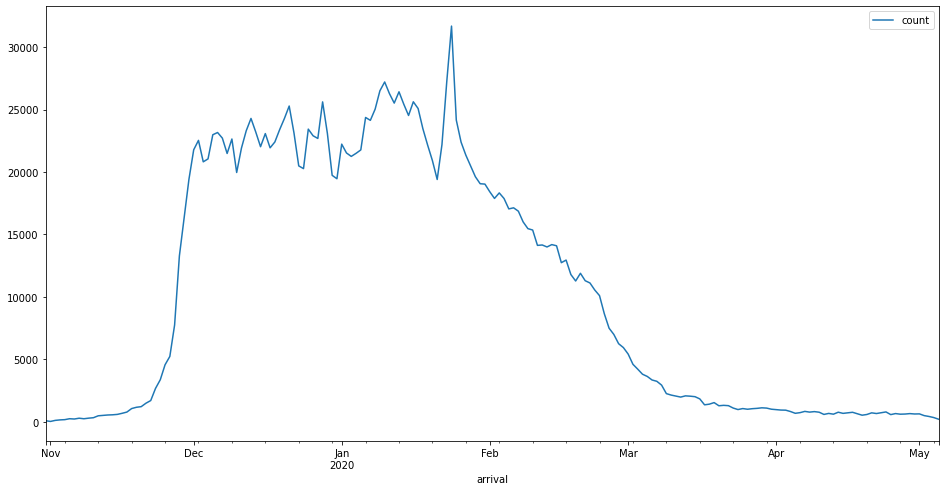

In [3]:

ds_y = pd.DataFrame(rm.groupby('arrival')['count'].sum())
ds_y.index=  pd.to_datetime(ds_y.index, format='%Y%m%d')

# 날자별 입국자(로밍등록자) 정리 dataset 확인
ds_y.plot(figsize=(16,8))
ds_y

,ae,at,cn,de,hk,jp,kh,kw,la,mm,my,no,pe,ph,pl,th,us,vn,hu,ma,mn,au,ch,fr,gb,in,iq,lk,qa,sg,uz,cz,dk,es,fi,id,nz,ru,sa,sk,...,tl,tp,vu,zw,rs,tk,ug,bz,bo,cy,na,pg,rw,bt,lr,mz,pr,tg,mk,an,cv,tt,md,ad,ga,gn,re,ky,bf,bj,cf,tc,ls,td,mr,to,ws,gm,ye,ml
arrival,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,8.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-01,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-02,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6.0,19.0,3.0,0.0,0.0,0.0,6.0,3.0,6.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-03,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,13.0,21.0,6.0,3.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-04,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,6.0,24.0,9.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,6.0,6.0,3.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,6.0,9.0,85,25.0,28.0,100,0.0,0.0,0.0,0.0,6.0,0.0,3.0,35.0,3.0,22.0,68.0,29.0,6.0,0.0,0.0,15.0,3.0,6.0,3.0,0.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,3.0,0.0,35.0,0.0,12.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-02,3.0,13.0,56,20.0,9.0,65,19.0,0.0,0.0,0.0,3.0,0.0,0.0,9.0,0.0,10.0,67.0,26.0,0.0,0.0,0.0,12.0,0.0,3.0,6.0,0.0,0.0,0.0,6.0,7.0,3.0,0.0,0.0,0.0,0.0,6.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-03,3.0,0.0,51,12.0,9.0,102,3.0,3.0,0.0,0.0,3.0,0.0,0.0,6.0,0.0,6.0,49.0,45.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,6.0,8.0,0.0,0.0,0.0,3.0,0.0,22.0,0.0,12.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


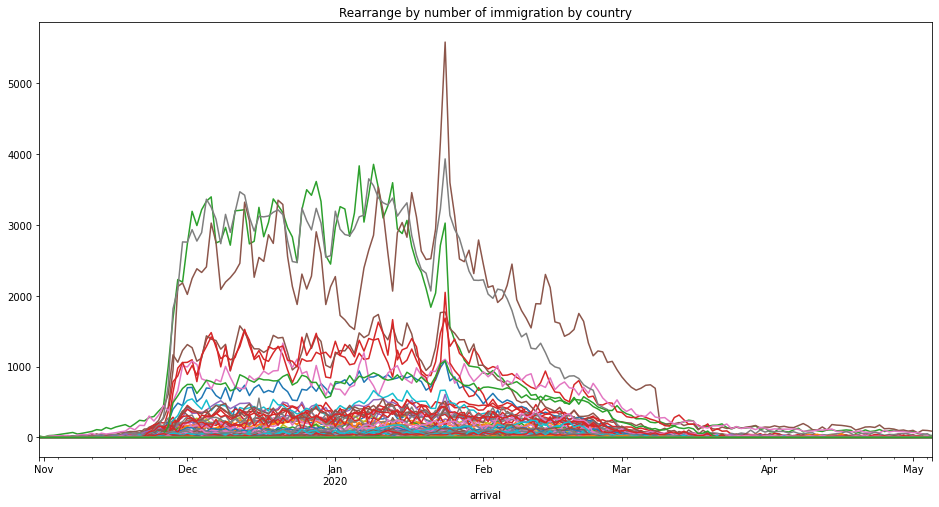

In [4]:

ar_iso = pd.DataFrame(rm.groupby(['arrival','iso'])['count'].sum())
rows = []
date = None
r = None
for row in ar_iso.iterrows():
    if date == row[0][0]:
        pass
    else:
        if not r is None:
            rows.append(r)
        r = {}
    r['arrival'] = row[0][0]
    r[row[0][1]] = row[1][0]
    date = row[0][0]
rows.append(r)
ds_iso = pd.DataFrame(rows)
ds_iso.fillna(0, inplace=True)
ds_iso = ds_iso.set_index('arrival')
#ds_iso['total'] = ar['count']
ds_iso.index =  ds_iso.index.astype('object')
#index을 datetime 으로 casting 한다.
ds_iso.index =  pd.to_datetime(ds_iso.index, format='%Y%m%d')
ds_iso.plot(legend=False,figsize=(16,8),title="Rearrange by number of immigration by country")
ds_iso

input x: (188, 174)
input y: (188,)
outout train_x: (144, 30, 174)
outout train_y: (144, 15)
outout test_x: (1, 30, 174)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 30, 128)           89216     
_________________________________________________________________
activation_5 (Activation)    (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 15, 64)            32832     
_________________________________________________________________
activation_6 (Activation)    (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 64)             0         

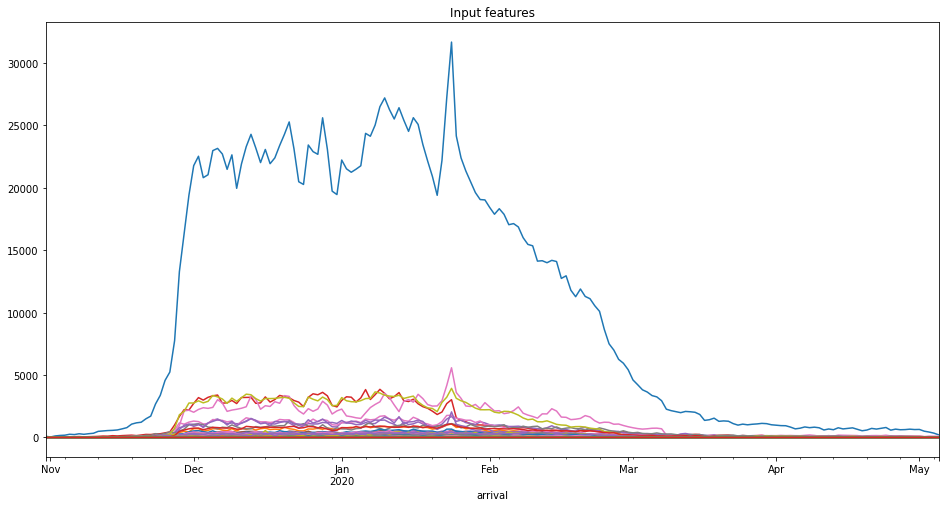

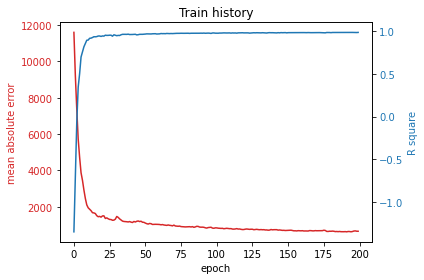

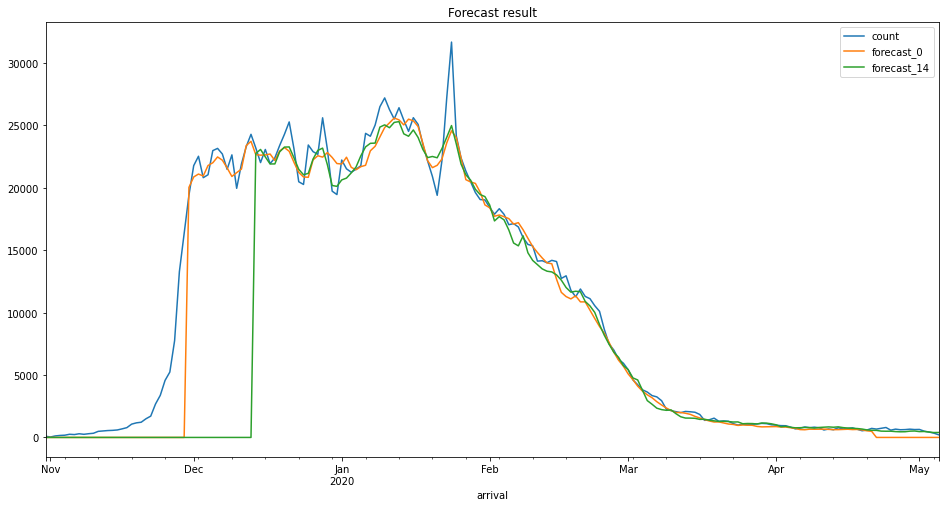

In [8]:
ds_y_iso = ds_y.join(ds_iso) # / np.max(ds_y.max())
ds_y_iso.plot(legend=False,figsize=(16,8),title='Input features')

train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso,ds_y)
model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=200,trial=1)
plot_train_result(hist)
predit_y = model.predict(train_x)
predit_y,predit_y.shape
compare_with_org_y(org_y=ds_y,comp_y=predit_y,title='Forecast result')

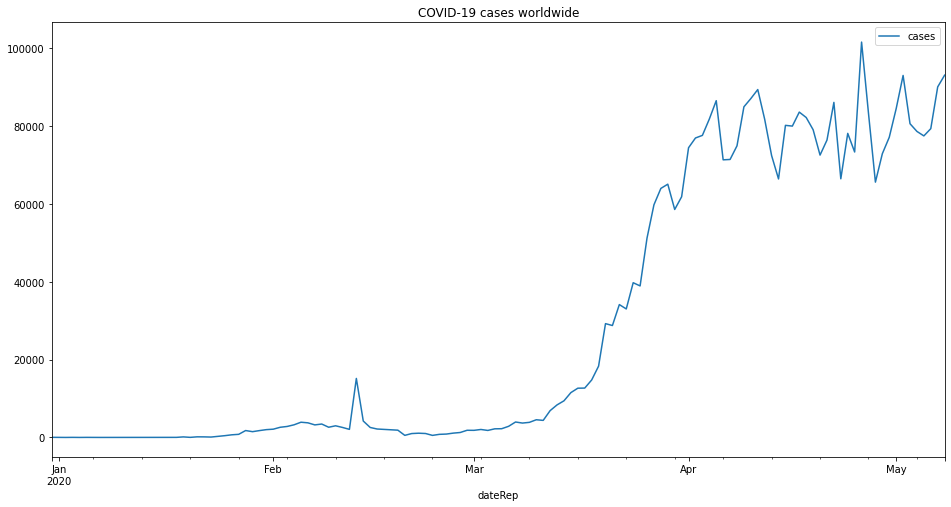

In [11]:
# 추가 데이터
# COVID-19 word wide dataset
# https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data

ds_cov_tp = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv",encoding="utf-8")
ds_cov = pd.DataFrame(ds_cov_tp.groupby('dateRep')['cases'].sum())
#date column을 datetime 으로 casting 한다.
ds_cov.index =  pd.to_datetime(ds_cov.index, format='%d/%m/%Y')
ds_cov = ds_cov.sort_index()
ds_cov.plot(figsize=(16,8),title='COVID-19 cases worldwide')


input x: (188, 175)
input y: (188,)
outout train_x: (144, 30, 175)
outout train_y: (144, 15)
outout test_x: (1, 30, 175)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 30, 128)           89728     
_________________________________________________________________
activation_13 (Activation)   (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 15, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 15, 64)            32832     
_________________________________________________________________
activation_14 (Activation)   (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 7, 64)             0         

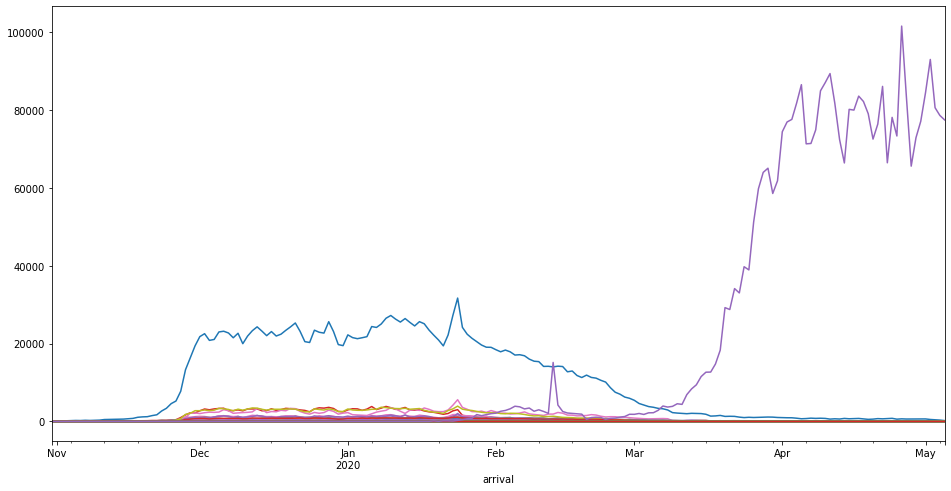

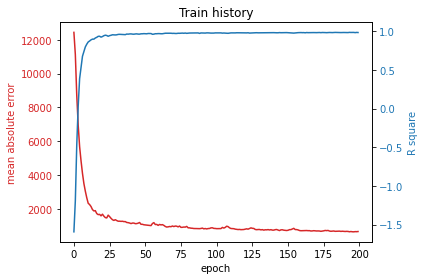

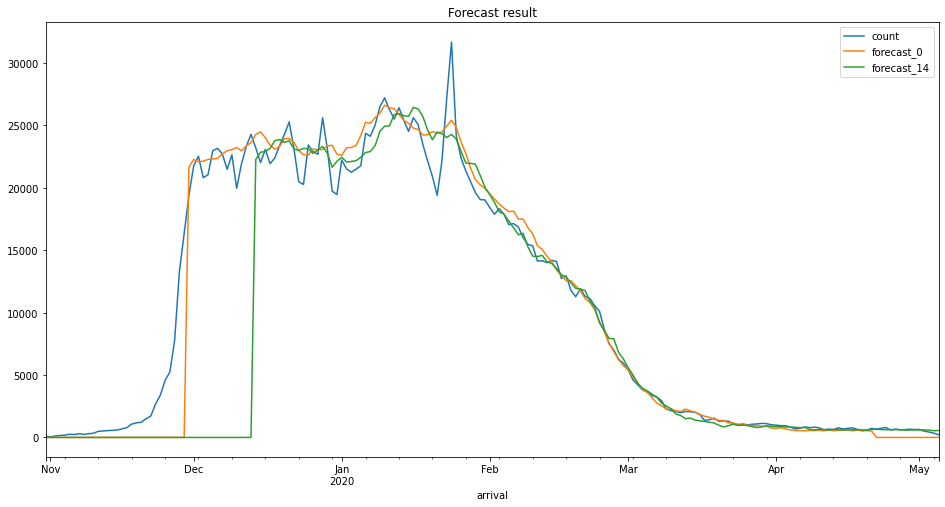

In [13]:
ds_y_iso_cov = ds_y_iso.join(ds_cov).fillna(0)
ds_y_iso_cov.plot(legend=False,figsize=(16,8),title='Input features')
train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov,ds_y)
model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=200,trial=1)
plot_train_result(hist)
predit_y = model.predict(train_x)
predit_y,predit_y.shape
compare_with_org_y(org_y=ds_y,comp_y=predit_y)

In [14]:
# 	1.2 News Data의 전처리
#		1.2.1 News Data load

# 뉴스 기사 정보를 읽어서... 나뉘어 있는 Dataset을 합친다.
ns1 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/NewsList.xls")
ns2 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/NewsList.xls")
ns3 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0506/NewsList.xls")

ds_ns_tp =pd.concat([ns1, ns2, ns3], ignore_index=True, sort=False)
ds_ns_tp

,파일명,제목,URL,수집일자,게시일자,채널명,감염병명,분류명
0,AFRO2019120200003,WHO supports Angola’s Government efforts to en...,https://www.afro.who.int/news/who-supports-ang...,2019-12-02 21:00:16.0,2019-12-02 00:00:00,AFRO,Poliomyelitis,Viral
1,AFRO2019120300001,African First Ladies laud progress against HIV...,https://www.afro.who.int/news/african-first-la...,2019-12-03 00:00:17.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
2,AFRO2019120300002,Eritrea Observed World AIDS Day 2019,https://www.afro.who.int/news/eritrea-observed...,2019-12-03 00:00:18.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
3,AFRO2019120400003,West and Central Africa Expands Access to HIV ...,https://www.afro.who.int/news/west-and-central...,2019-12-04 03:00:14.0,2019-12-03 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
4,AFRO2019120400004,Nearly 23 million voluntary male medical circu...,https://www.afro.who.int/news/nearly-23-millio...,2019-12-04 22:00:14.0,2019-12-04 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
...,...,...,...,...,...,...,...,...
112608,XINH2020050500081,Russia's top spacecraft designer reportedly di...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-05 23:01:00.0,2020-05-05 21:06:31,Xinhua,COVID-19,Viral
112609,XINH2020050500083,Glimpse of a world under pandemic,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-05 23:01:00.0,2020-05-05 21:00:35,Xinhua,COVID-19,Viral
112610,XINH2020050600003,Chinese clinical experience on COVID-19 treatm...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-06 00:00:51.0,2020-05-05 22:03:48,Xinhua,COVID-19,Viral
112611,XINH2020050600005,Volvo Cars sales in China returns to growth in...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-06 01:00:57.0,2020-05-05 23:39:14,Xinhua,COVID-19,Viral


,파일명,제목,URL,수집일자,게시일자,채널명,감염병명,분류명
70,AFRO2020012600001,Rwanda Public Notice on Novel Coronavirus,https://www.afro.who.int/news/rwanda-public-no...,2020-01-26 00:00:16.0,2020-01-25,AFRO,COVID-19,Viral
72,AFRO2020013100001,WHO ramps up preparedness for novel coronaviru...,https://www.afro.who.int/news/who-ramps-prepar...,2020-01-31 20:00:16.0,2020-01-31,AFRO,COVID-19,Viral
76,AFRO2020020100002,Rwanda hastens safety measures against novel c...,https://www.afro.who.int/news/rwanda-hastens-s...,2020-02-01 21:00:19.0,2020-02-01,AFRO,COVID-19,Viral
77,AFRO2020020300001,Eritrea Strengthening Preparedness to 2019 nov...,https://www.afro.who.int/news/eritrea-strength...,2020-02-03 03:00:12.0,2020-02-02,AFRO,COVID-19,Viral
81,AFRO2020020500001,WHO supports Botswana’s preparedness and respo...,https://www.afro.who.int/news/who-supports-bot...,2020-02-05 02:00:16.0,2020-02-04,AFRO,COVID-19,Viral
...,...,...,...,...,...,...,...,...
112607,XINH2020050500080,"Spotlight: Europeans restart ""normal"" life in ...",http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-05 23:01:04.0,2020-05-05,Xinhua,COVID-19,Viral
112608,XINH2020050500081,Russia's top spacecraft designer reportedly di...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-05 23:01:00.0,2020-05-05,Xinhua,COVID-19,Viral
112609,XINH2020050500083,Glimpse of a world under pandemic,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-05 23:01:00.0,2020-05-05,Xinhua,COVID-19,Viral
112610,XINH2020050600003,Chinese clinical experience on COVID-19 treatm...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-06 00:00:51.0,2020-05-05,Xinhua,COVID-19,Viral


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

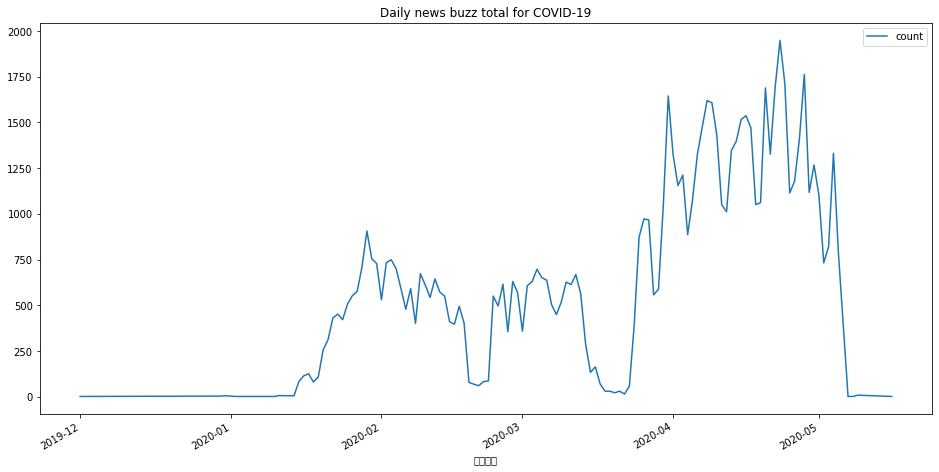

In [19]:
# 		1.2.2 News Data에 대한 EDA
# 			1.2.2.1 게시일을 기준으로 News buzz의 합산

ds_ns_tp = ds_ns_tp.loc[ds_ns_tp['감염병명'] == 'COVID-19']
ds_ns_tp['게시일자'] =  ds_ns_tp['게시일자'].str[:10]
ds_ns = pd.DataFrame(ds_ns_tp.groupby('게시일자')['감염병명'].count())
ds_ns = ds_ns.loc[ds_ns.index >= '2019-10-31']
ds_ns.index = pd.to_datetime(ds_ns.index, format='%Y-%m-%d')
ds_ns = ds_ns.rename(columns={"감염병명":"count"})
ds_ns.plot(figsize=(16,8),title="Daily news buzz total for COVID-19")
ds_ns_tp

In [21]:
###########################################################################################################
# dolmani38의 google drive에서 corpus_embeddings.emb 의 다운로드                                          #
# dolmani38이외 Test 사용자는 이번 Cell은 실행하지 말고 다음 Cell에서 corpus_embeddings.emb를 만드세요.   #
###########################################################################################################
!pip install PyDrive
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user(clear_output=False)
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({"id":"1FN7V0RxGACTNkusH9iQgFjXhicv1Lzei"})   # replace the id with id of file you want to access
downloaded.GetContentFile("corpus_embeddings.emb")        # replace the file name with your file

import os.path
from os import path

if path.exists("corpus_embeddings.emb"):
    print("Download complete!!")

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=JVvdnm62hEHZ2hfKiGDjvamL1w6soT&code_challenge=AntTlMZTPy-4AH_4trkJn-mNfWg_AmaWjuVeJCBYl8M&prompt=consent&code_challenge_method=S256&access_type=offline

Enter verification code: ··········
Download complete!!


In [22]:
# 			1.2.3.2 News의 BERT embedding

# 실 Contents는 사용하지 않고 title만 BERT embedding 처리...
# 시간 상당히 오래 걸림, 약 1시간 30분

#Start BERT embedding for news title...81785
#Length of corpus:81785
#Complete!!
#shape of corpus_embeddings :  (81785, 768)
#length of corpus :  81785
#End... elapsed time : 1:26:13.748154

# Sentence Transformers: Multilingual Sentence Embeddings using BERT / RoBERTa / XLM-RoBERTa & Co. with PyTorch
# https://github.com/UKPLab/sentence-transformers

!pip install -U sentence-transformers

from timeit import default_timer as timer
from datetime import timedelta
import os.path
from os import path
import dill
from sentence_transformers import SentenceTransformer
import scipy.spatial

start = timer()

# embedder download...
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

print("Start BERT embedding for news title...{}".format(len(ds_ns_tp)))

# 뉴스 title만 corpus로 추출
# 기사 내용도 할수는 있으나 시간 넘 걸림...
corpus = []
for row in ds_ns_tp.iterrows():
    file_name = row[1][0]
    title = str(row[1][1])
    pub_datetime = row[1][4]
    corpus.append(title.lower())
    #print("{},{},{}".format(file_name,pub_datetime,title))

print("Length of corpus:{}".format(len(corpus)))

if path.exists("corpus_embeddings.emb"):
    print("load from corpus_embeddings file...")
    file = open("corpus_embeddings.emb", 'rb')
    corpus_embeddings = dill.load(file)
    file.close()

else:
    corpus_embeddings = embedder.encode(corpus,show_progress_bar=True)   

    print("Wait! saving corpus_embeddings...")    
    file = open("corpus_embeddings.emb", 'wb')
    dill.dump(corpus_embeddings, file)
    file.close()

print("Complete!!")

corpus_embeddings = np.asarray(corpus_embeddings)        
print("shape of corpus_embeddings : ",corpus_embeddings.shape)
print("length of corpus : ",len(corpus))

#temp_ds = cov_news #.head(10)
docv_model = {}
for i, row in enumerate(ds_ns_tp.iterrows()):
    docv_model[row[1][0]] = corpus_embeddings[i]

len(docv_model)

end = timer()

print("End... elapsed time : {}".format(timedelta(seconds=end-start)))

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.6/dist-packages (0.2.6.1)
Start BERT embedding for news title...81785
Length of corpus:81785
load from corpus_embeddings file...
Complete!!
shape of corpus_embeddings :  (81785, 768)
length of corpus :  81785
End... elapsed time : 0:00:21.783948


In [23]:
# 			1.2.3.3 News data의 feature 추출 (일종의 차원 축소)

# News에서 6개 feature 추출
# worse feature : 코로나 상황이 더 나빠지고 있다는 뉴스
# better feature : 상황이 좋아 지고 있나는 뉴스
# block feature : 격리, 입출입 차단 강화 관련 뉴스
# premit feature : 격리 해제, 입출입 완화 관련 뉴스
# yes_korea feature : 한국에 긍정적 내용 뉴스
# no_korea feature : 한국에 부정적 내용 뉴스

# 6개 feature를 추출하기 위해, 각 특성을 나타내는 간략한 sentence를 수동으로 만들고, 이를 전체 corpus_embeddings 에서 유사한 내용의 뉴스를 추출하여
# 해당 뉴스를 유사 내용으로 간주하고 labeling 한다.

def searchSentence(queries,Threshold_score=0.60, Topn=0,must_has_word=[]):
    index = {}
    n = len(queries)
    query_embeddings = embedder.encode(queries)
    for query, query_embedding in zip(queries, query_embeddings):
        distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

        results = zip(range(len(distances)), distances)
        results = sorted(results, key=lambda x: x[1])
        
        for idx, distance in results[0:len(results) if Topn==0 else Topn]:
          score = 1-distance
          if not idx in index:
            index[idx] = 0.0
          if score > Threshold_score:
              if len(must_has_word) > 0:
                  if corpus[idx].strip().find(must_has_word[0]) >= 0:
                      index[idx] += float(score/n)
              else:
                  index[idx] += float(score/n)
              #print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))
    return index

ds_ns_tp.reset_index(inplace = True, drop = True) 

queries_dict = {
    'worse':([],['infected corona','infected coronavirus ','increase confirmed','increase Infections','infectious increase','confirmed case incease','deaths incease','patients incease','lack prepare','not prepared','lack medical','lack preparedness']),
    'better':([],['decrease confirmed','decrease Infections','infectious decrease','confirmed case decrease','No confirmed','No case','deaths decrease','patients decrease','send supplies','order supplies','donates supplies','gives supplies','situation stability','situation stable','remains stable']),
    'block':([],['immigrants block','immigrants restrict','immigration block','immigration restrict','entrants block','entrants restrict','entry block','entry restrict','tourist block','tourist restrict','tourist Isolation','traveler block','traveler restrict','traveler Isolation','immigrants quarantine','entrants quarantine','entry quarantine','tourist quarantine','reinforce quarantine','reinforce diagnosis']),
    'permit':([],['immigrants permit','immigrants ease','immigration permit','immigration ease','entrants permit','entrants ease','entry permit','entry ease','tourist permit','tourist ease','release tourist ','traveler permit','release quarantine','release quarantine']),
    'yes_korea':(['korea'],['korea decrease confirmed','korea decrease Infections','korea infectious decrease','korea confirmed case decrease','korea No confirmed','korea No case','korea deaths decrease','korea patients decrease','korea send supplies','korea order supplies','korea donates supplies','korea gives supplies','korea situation stability','korea situation stable','korea remains stable','korea immigrants permit','korea immigrants ease','korea immigration permit','korea immigration ease','korea entrants permit','korea entrants ease','korea entry permit','korea entry ease','korea tourist permit','korea tourist ease','korea release tourist ','korea traveler permit','korea release quarantine','korea release quarantine']),
    'no_korea':(['korea'],['korea infected corona','korea infected coronavirus ','korea increase confirmed','korea increase Infections','korea infectious increase','korea confirmed case incease','korea deaths incease','korea patients incease','korea lack prepare','korea not prepared','korea lack medical','korea lack preparedness','korea immigrants block','korea immigrants restrict','korea immigration block','korea immigration restrict','korea entrants block','korea entrants restrict','korea entry block','korea entry restrict','korea tourist block','korea tourist restrict','korea tourist Isolation','korea traveler block','korea traveler restrict','korea traveler Isolation','korea immigrants quarantine','korea entrants quarantine','korea entry quarantine','korea tourist quarantine','korea reinforce quarantine','korea reinforce diagnosis'])
}
# Query sentences:

for query_key in queries_dict.keys():
  ds_ns_tp[query_key] = 0
  idxs = searchSentence(queries_dict[query_key][1],Threshold_score = 0.6,must_has_word=queries_dict[query_key][0])
  print('{} result rows:{} query count:{}'.format(query_key,len(idxs),len(queries_dict[query_key][1])))
  ds_ns_tp.loc[list(idxs.keys()),query_key] = list(idxs.values())

ds_ns_tp[['게시일자','worse','better','block','permit','yes_korea','no_korea','제목']]


worse result rows:81785 query count:12
better result rows:81785 query count:15
block result rows:81785 query count:20
permit result rows:81785 query count:14
yes_korea result rows:81785 query count:29
no_korea result rows:81785 query count:32


,게시일자,worse,better,block,permit,yes_korea,no_korea,제목
0,2020-01-25,0.054946,0.0,0.0,0.0,0.0,0.0,Rwanda Public Notice on Novel Coronavirus
1,2020-01-31,0.000000,0.0,0.0,0.0,0.0,0.0,WHO ramps up preparedness for novel coronaviru...
2,2020-02-01,0.051934,0.0,0.0,0.0,0.0,0.0,Rwanda hastens safety measures against novel c...
3,2020-02-02,0.000000,0.0,0.0,0.0,0.0,0.0,Eritrea Strengthening Preparedness to 2019 nov...
4,2020-02-04,0.000000,0.0,0.0,0.0,0.0,0.0,WHO supports Botswana’s preparedness and respo...
...,...,...,...,...,...,...,...,...
81780,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,"Spotlight: Europeans restart ""normal"" life in ..."
81781,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,Russia's top spacecraft designer reportedly di...
81782,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,Glimpse of a world under pandemic
81783,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,Chinese clinical experience on COVID-19 treatm...


In [24]:
# 6개 feature를 일자 기준 하나의 dataframe으로 join

cov_1 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['worse'].sum())
cov_2 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['better'].sum())
cov_3 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['block'].sum())
cov_4 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['permit'].sum())
cov_5 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['yes_korea'].sum())
cov_6 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['no_korea'].sum())

ds_ns_cov = ds_ns.join(cov_1).join(cov_2).join(cov_3).join(cov_4).join(cov_5).join(cov_6)
ds_ns_cov

,count,worse,better,block,permit,yes_korea,no_korea
게시일자,,,,,,,
2019-12-01,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-14,2,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-30,3,0.058952,0.000000,0.000000,0.000000,0.0,0.0
2019-12-31,5,0.170601,0.000000,0.000000,0.000000,0.0,0.0
2020-01-02,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...
2020-05-05,793,5.810915,0.516218,0.435219,0.223337,0.0,0.0
2020-05-07,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2020-05-08,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

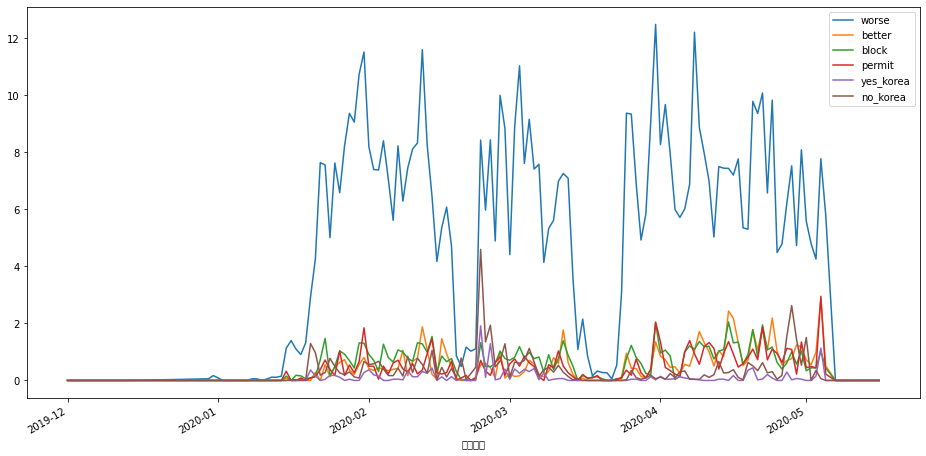

In [25]:
# 추출된 feature의 추세 확인
ds_ns_cov.plot(y=['worse','better','block','permit','yes_korea','no_korea'],figsize=(16,8))

,worse,better,block,permit,yes_korea,no_korea
게시일자,,,,,,
2019-12-01,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-14,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-30,0.019651,0.000000,0.000000,0.000000,0.0,0.0
2019-12-31,0.034120,0.000000,0.000000,0.000000,0.0,0.0
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...
2020-05-05,0.007328,0.000651,0.000549,0.000282,0.0,0.0
2020-05-07,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2020-05-08,0.000000,0.000000,0.000000,0.000000,0.0,0.0


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

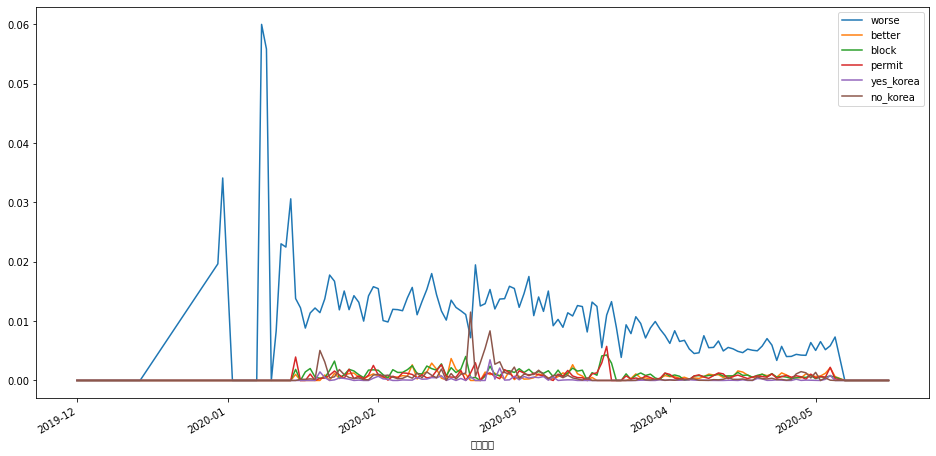

In [27]:
#			1.2.3.4 News feature의 Normalization

ds_ns_cov_n = pd.DataFrame({'worse':ds_ns_cov['worse']/ds_ns_cov['count']})
ds_ns_cov_n["better"] = ds_ns_cov['better']/ds_ns_cov['count']
ds_ns_cov_n["block"] = ds_ns_cov['block']/ds_ns_cov['count']
ds_ns_cov_n["permit"] = ds_ns_cov['permit']/ds_ns_cov['count']
ds_ns_cov_n["yes_korea"] = ds_ns_cov['yes_korea']/ds_ns_cov['count']
ds_ns_cov_n["no_korea"] = ds_ns_cov['no_korea']/ds_ns_cov['count']
# Normalization 한 feature의 추세 확인
ds_ns_cov_n.plot(figsize=(16,8))
ds_ns_cov_n

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

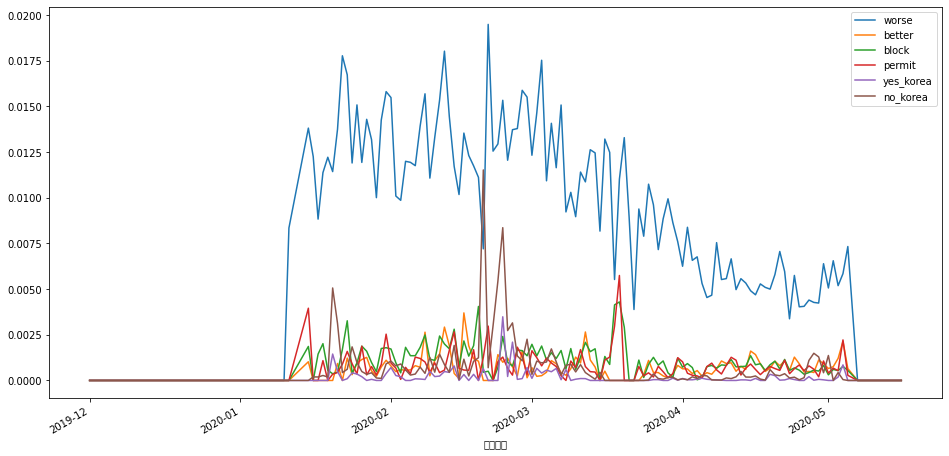

In [28]:
#			1.2.3.5 Outlier 제거

# worse 성분의 outlier filtering
ds_ns_cov_n_f = ds_ns_cov_n[ds_ns_cov_n["worse"] < 0.0195]
ds_ns_cov_n_f.plot(figsize=(16,8))

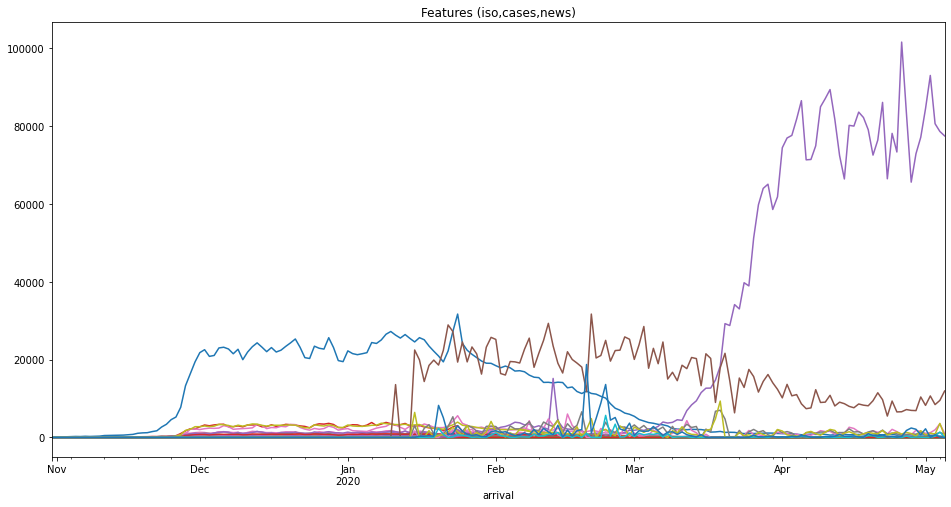

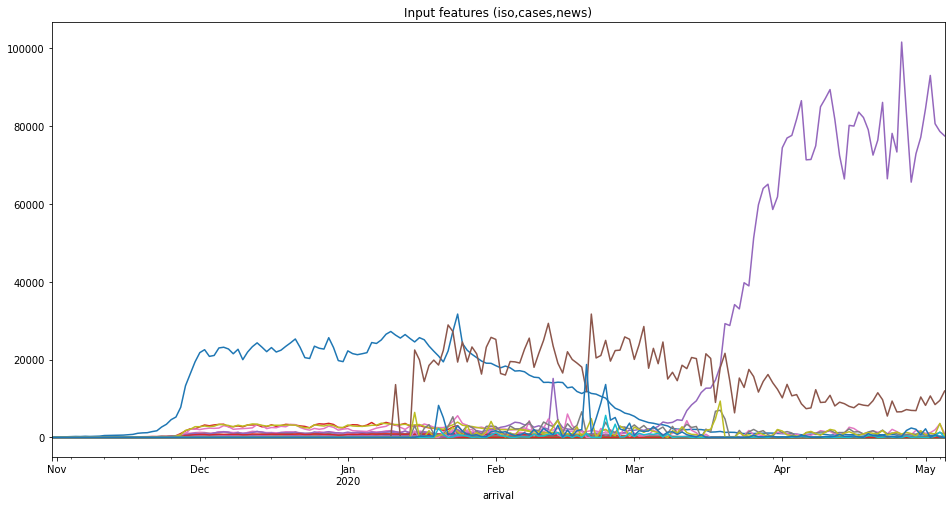

In [48]:
# ds_y 크기로 scale 조정
ds_ns_cov_n_f_s = (ds_ns_cov_n_f / np.max(ds_ns_cov_n_f.max())) * np.max(ds_y.max())
ds_y_iso_cov_ns = ds_y_iso_cov.join(ds_ns_cov_n_f_s).fillna(0)
ds_y_iso_cov_ns.plot(legend=False,figsize=(16,8),title='Input features (iso,cases,news)')

input x: (188, 181)
input y: (188,)
outout train_x: (144, 30, 181)
outout train_y: (144, 15)
outout test_x: (1, 30, 181)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 30, 128)           92800     
_________________________________________________________________
activation_41 (Activation)   (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 15, 128)           0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 15, 64)            32832     
_________________________________________________________________
activation_42 (Activation)   (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 7, 64)             0        

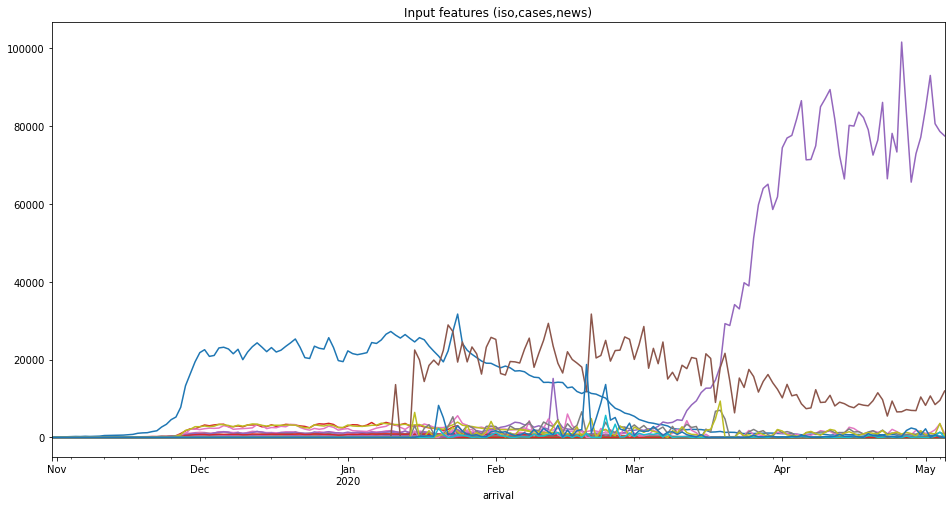

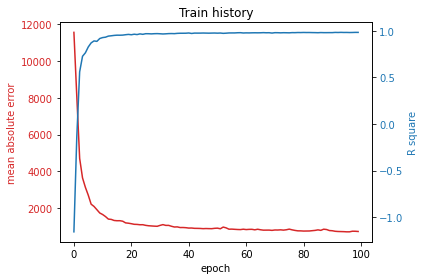

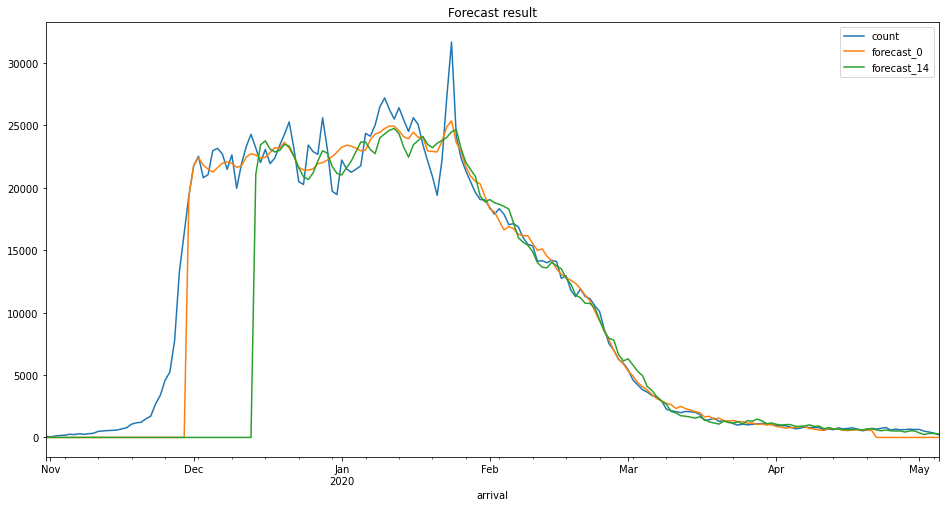

In [85]:
ds_y_iso_cov_ns.plot(legend=False,figsize=(16,8),title='Input features (iso,cases,news)')
train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y)
model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=100,trial=1)
plot_train_result(hist)
predit_y = model.predict(train_x)
predit_y,predit_y.shape
compare_with_org_y(org_y=ds_y,comp_y=predit_y)

,date,roaming register forecate,immigrantion forecast
0,2020-05-06,516.769165,2153
1,2020-05-07,989.068176,4121
2,2020-05-08,430.717651,1794
3,2020-05-09,893.798523,3724
4,2020-05-10,923.090027,3846
5,2020-05-11,1151.232178,4796
6,2020-05-12,765.504944,3189
7,2020-05-13,825.691772,3440
8,2020-05-14,338.955475,1412
9,2020-05-15,758.047729,3158


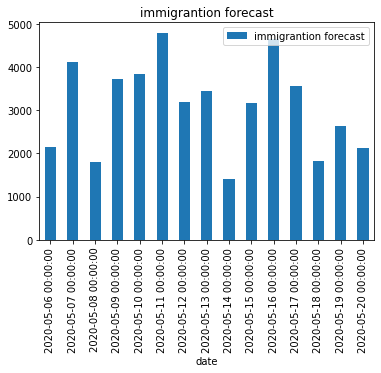

In [86]:

predit_y = model.predict(test_x)
predit_y, predit_y.shape

display_result(predit_y,ds_y)

In [98]:

import dill
from keras.models import model_from_json


def ensemble_train(train_x,train_y,ensemble_count=25,epoch=200):
    model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
    ensemble = []
    for i in range(ensemble_count):
      json_file = open("model.json", "r")
      loaded_model_json = json_file.read()
      json_file.close()
      model = model_from_json(loaded_model_json) 
      model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])
      model,hist = train_model(model,train_x,train_y,epochs=epoch,trial=(i+1))
      ensemble.append(model)
        
    print("Wait! saving ensemble model...")    
    file = open("ensemble.mdl", 'wb')
    dill.dump(ensemble, file)
    file.close()

    print("Complete!!")
    return ensemble

ensemble_model = ensemble_train(train_x,train_y,ensemble_count=10,epoch=100)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 30, 128)           92800     
_________________________________________________________________
activation_49 (Activation)   (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 15, 128)           0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 15, 64)            32832     
_________________________________________________________________
activation_50 (Activation)   (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 7, 64)             0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 7, 32)           

In [0]:

# 		ensemble_predict method define~
def ensemble_predict(ensemble_model,input_x):
  if ensemble_model is None:
    print("load from model file...")
    file = open("ensemble.mdl", 'rb')
    ensemble = dill.load(file)
    file.close()
  ensemble_predit_y =  np.asarray([m.predict(input_x) for m in ensemble_model])
  predit_y = np.mean(ensemble_predit_y,axis=0)
  return predit_y, ensemble_predit_y

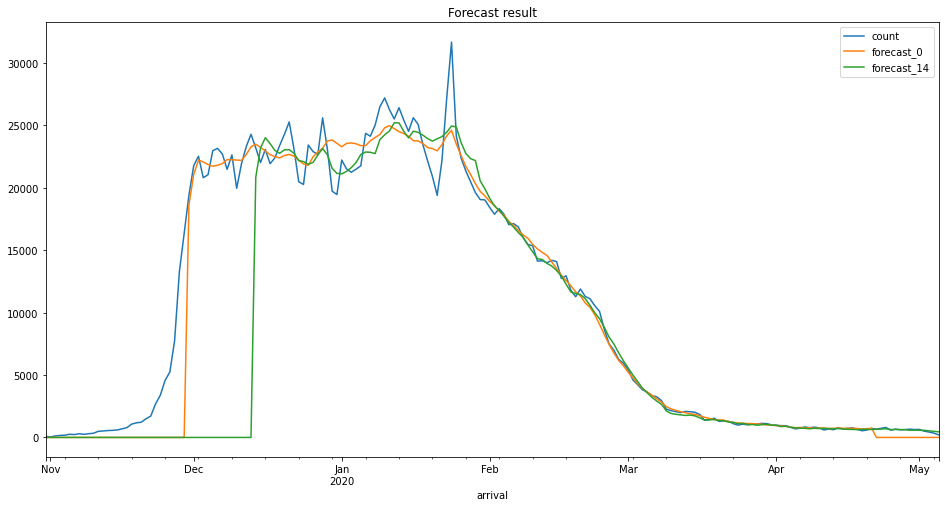

In [100]:
predit_y,ensemble_predit_y = ensemble_predict(ensemble_model,train_x)
predit_y,predit_y.shape
compare_with_org_y(org_y=ds_y,comp_y=predit_y)

,date,roaming register forecate,immigrantion forecast
0,2020-05-06,791.838867,3299
1,2020-05-07,718.951294,2995
2,2020-05-08,667.237671,2780
3,2020-05-09,694.050659,2891
4,2020-05-10,760.693237,3169
5,2020-05-11,720.413208,3001
6,2020-05-12,650.897034,2712
7,2020-05-13,791.668091,3298
8,2020-05-14,770.918579,3212
9,2020-05-15,749.628784,3123


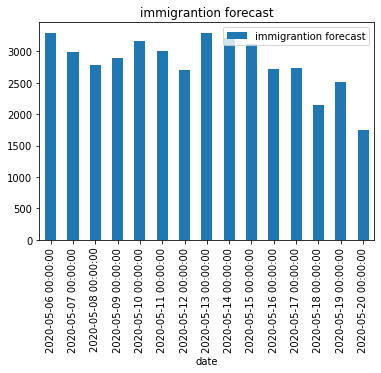

In [101]:
predit_y,ensemble_predit_y = ensemble_predict(ensemble_model,test_x)
predit_y, predit_y.shape
rs = display_result(predit_y,ds_y)
rs

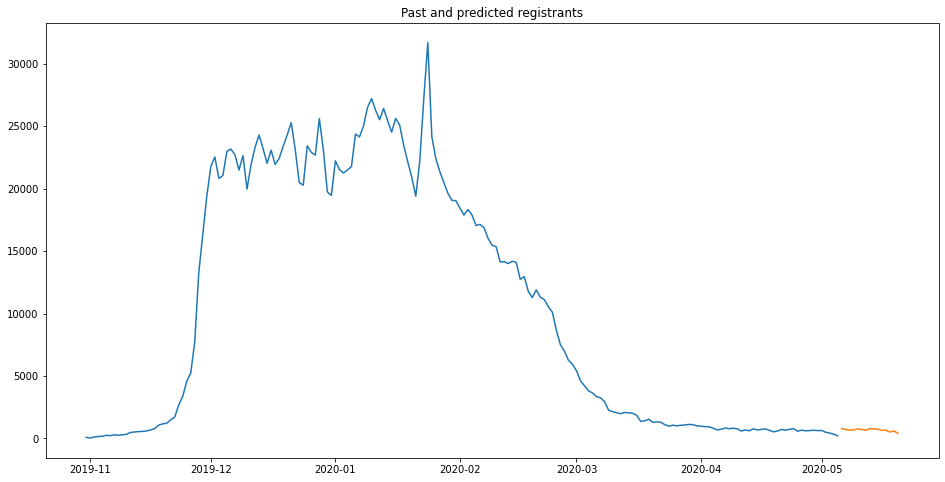

In [102]:
# shift test predictions for plotting
rs_d = rs[['date','roaming register forecate']].set_index('date')
# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(ds_y)
plt.plot(rs_d)
plt.title('Past and predicted registrants')
plt.show()

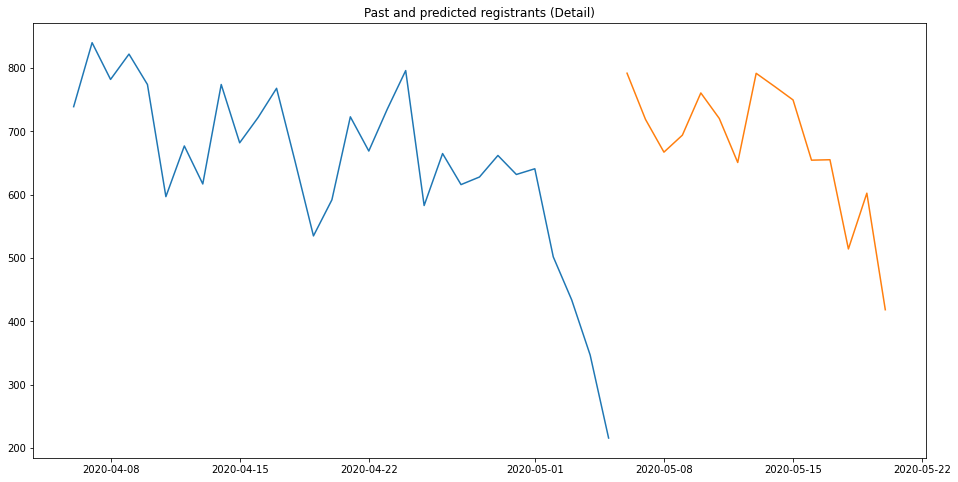

In [103]:
# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(ds_y[len(ds_y)-30:len(ds_y)])
plt.plot(rs_d)
plt.title('Past and predicted registrants (Detail)')
plt.show()

In [104]:
#100회 시행기준, 통계적 신뢰수준 95에서 %일자별 예측 입국자 구간 분석

import numpy as np
import scipy as sp
import scipy.stats
from datetime import datetime, timedelta

def mean_confidence_interval(data, confidence=0.95):
       a = 1.0*np.array(data)
       n = len(a)
       m, se = np.mean(a), scipy.stats.sem(a)
       h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
       std = np.std(np.array(data))
       return m, m-h, m+h,std 

def statistical_results_analysis(ensemble_predit_y,ds_y, title=None):
  predic_ds = []
  last_date = ds_y.index[-1]
  ept = ensemble_predit_y.T
  for forecast_d in ept[:,0,:]:
    last_date += timedelta(days=1)
    m, mi,ma,std = mean_confidence_interval(forecast_d)
    predic_ds.append({'date':last_date,'roaming register forecast(RRF)':int(m),'min':int(mi),'max':int(ma),'Forecast within the 95% confidence interval': str(int(mi)) + ' ~ ' + str(int(ma)),'Standard Deviation':std,'Immigrantion forecast':int(m * 100/24)})

  return pd.DataFrame(predic_ds).set_index('date')

ds_s_r = statistical_results_analysis(ensemble_predit_y,ds_y)
ds_s_r.drop(columns=['min','max'])

,roaming register forecast(RRF),Forecast within the 95% confidence interval,Standard Deviation,Immigrantion forecast
date,,,,
2020-05-06,791,664 ~ 918,168.578842,3299
2020-05-07,718,560 ~ 877,209.649155,2995
2020-05-08,667,509 ~ 825,209.486450,2780
2020-05-09,694,498 ~ 889,259.819519,2891
2020-05-10,760,630 ~ 890,172.227097,3169
2020-05-11,720,611 ~ 829,144.450104,3001
2020-05-12,650,533 ~ 768,155.965256,2712
2020-05-13,791,663 ~ 919,170.142105,3298
2020-05-14,770,648 ~ 893,162.331482,3212


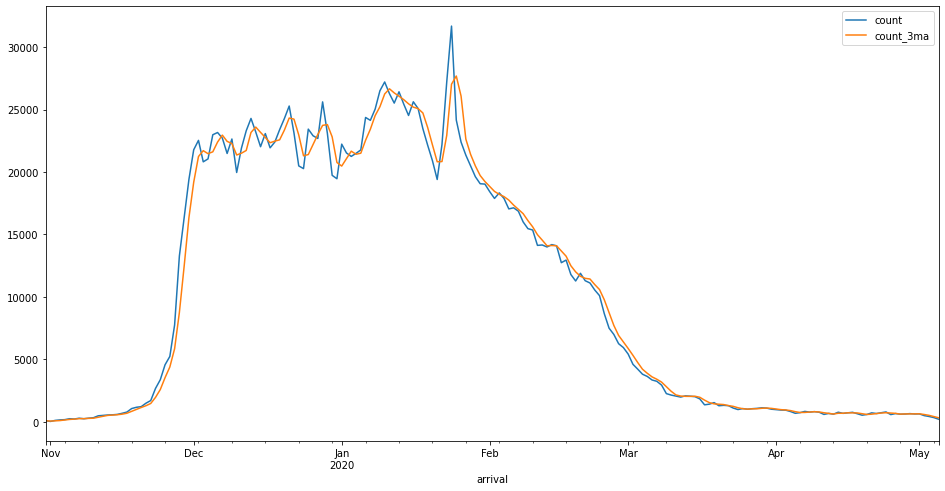

In [107]:
# 동일한 방법이나 y값을 3일 구간평균을 적용 -> 실 예측율을 높인다.
ds_y_3ma = pd.DataFrame()
ds_y_3ma['count_3ma'] = ds_y['count'].rolling(window=3, min_periods=0).mean()
ds_y.join(ds_y_3ma).plot(figsize=(16,8))


input x: (188, 181)
input y: (188,)
outout train_x: (144, 30, 181)
outout train_y: (144, 15)
outout test_x: (1, 30, 181)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 30, 128)           92800     
_________________________________________________________________
activation_53 (Activation)   (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 15, 128)           0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 15, 64)            32832     
_________________________________________________________________
activation_54 (Activation)   (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 7, 64)             0        

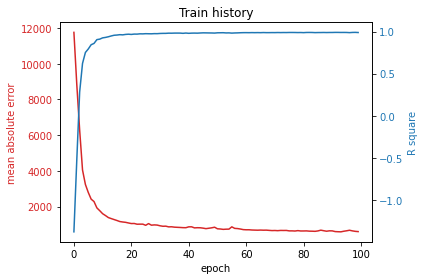

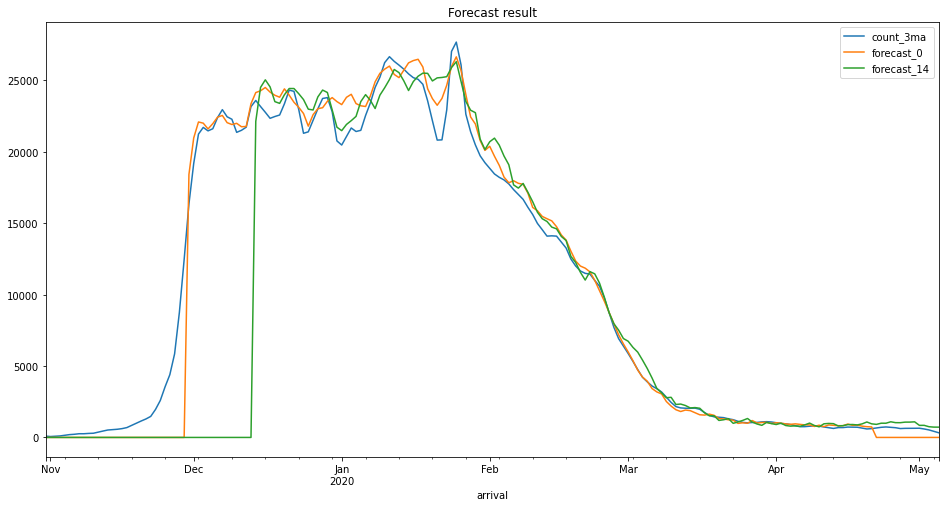

In [110]:
train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y_3ma)
model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=100,trial=1)
plot_train_result(hist)
predit_y = model.predict(train_x)
predit_y,predit_y.shape
compare_with_org_y(org_y=ds_y_3ma,comp_y=predit_y)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_43 (Conv1D)           (None, 30, 128)           92800     
_________________________________________________________________
activation_57 (Activation)   (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 15, 128)           0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 15, 64)            32832     
_________________________________________________________________
activation_58 (Activation)   (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 7, 64)             0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 7, 32)           

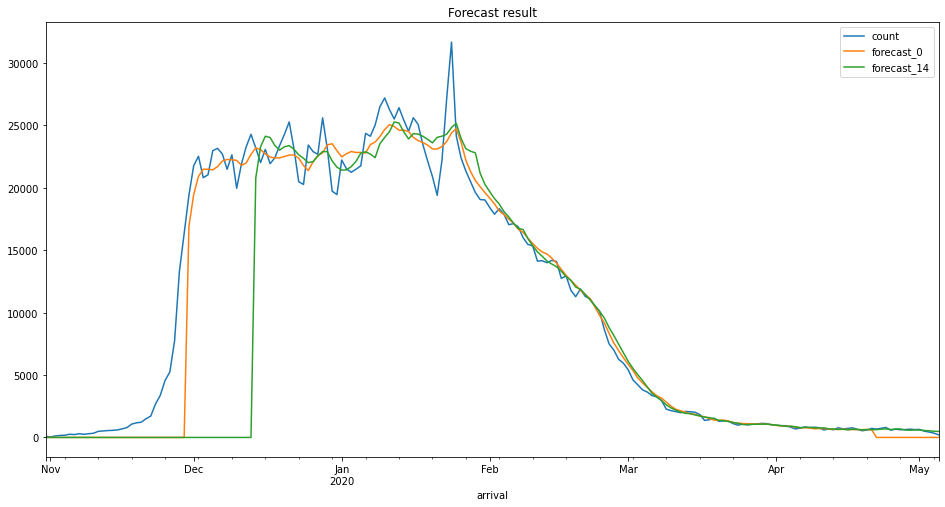

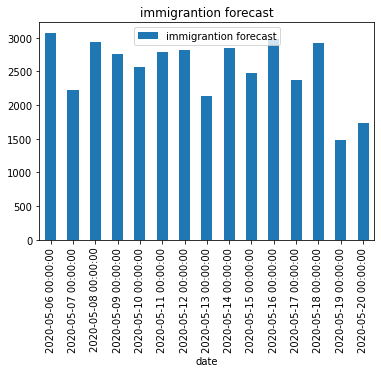

In [112]:
ensemble_model = ensemble_train(train_x,train_y,ensemble_count=10,epoch=100)
predit_y,ensemble_predit_y = ensemble_predict(ensemble_model,train_x)
compare_with_org_y(org_y=ds_y,comp_y=predit_y)

,date,roaming register forecate,immigrantion forecast
0,2020-05-06,738.279175,3076
1,2020-05-07,535.775696,2232
2,2020-05-08,704.040161,2933
3,2020-05-09,662.893921,2762
4,2020-05-10,615.158203,2563
5,2020-05-11,668.852539,2786
6,2020-05-12,677.161743,2821
7,2020-05-13,511.332428,2130
8,2020-05-14,684.341492,2851
9,2020-05-15,595.110840,2479


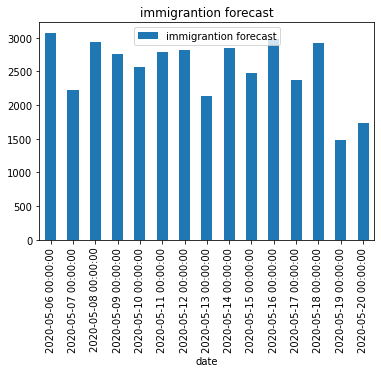

In [117]:
predit_y,ensemble_predit_y = ensemble_predict(ensemble_model,test_x)
predit_y, predit_y.shape
rs = display_result(predit_y,ds_y)
rs

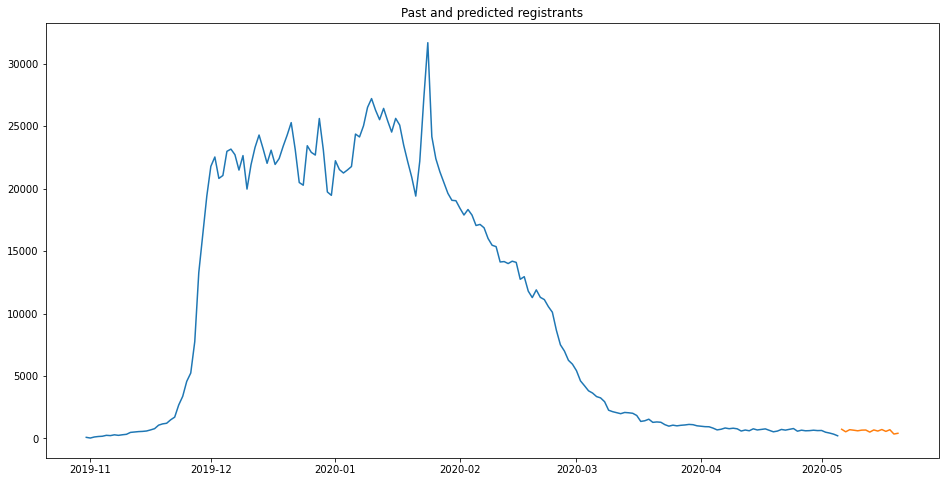

In [118]:
# shift test predictions for plotting
rs_d = rs[['date','roaming register forecate']].set_index('date')
# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(ds_y)
plt.plot(rs_d)
plt.title('Past and predicted registrants')
plt.show()

In [119]:
ds_s_r = statistical_results_analysis(ensemble_predit_y,ds_y)
print('Standard Deviation:',np.mean(ds_s_r['Standard Deviation']))
ds_s_r.drop(columns=['min','max'])

Standard Deviation: 238.85553181966145


,roaming register forecast(RRF),Forecast within the 95% confidence interval,Standard Deviation,Immigrantion forecast
date,,,,
2020-05-06,738,595 ~ 880,188.755417,3076
2020-05-07,535,451 ~ 620,112.097870,2232
2020-05-08,704,440 ~ 967,349.079956,2933
2020-05-09,662,501 ~ 823,213.473022,2762
2020-05-10,615,409 ~ 820,272.811035,2563
2020-05-11,668,488 ~ 849,239.147552,2786
2020-05-12,677,490 ~ 863,247.613785,2821
2020-05-13,511,367 ~ 655,191.094360,2130
2020-05-14,684,541 ~ 827,189.671997,2851


input x: (188, 181)
input y: (188, 181)
outout train_x: (168, 20, 181)
outout train_y: (168, 181)
outout test_x: (1, 20, 181)
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_124 (Conv1D)          (None, 20, 128)           92800     
_________________________________________________________________
activation_165 (Activation)  (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_124 (MaxPoolin (None, 10, 128)           0         
_________________________________________________________________
conv1d_125 (Conv1D)          (None, 10, 128)           65664     
_________________________________________________________________
activation_166 (Activation)  (None, 10, 128)           0         
_________________________________________________________________
max_pooling1d_125 (MaxPoolin (None, 5, 128)            0   

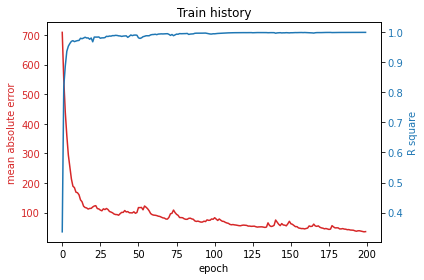

,date,roaming register forecate,immigrantion forecast
0,2020-05-06,224.785065,936
1,2020-05-07,882.164307,3675
2,2020-05-08,494.165253,2059
3,2020-05-09,568.112244,2367
4,2020-05-10,604.839478,2520
5,2020-05-11,580.921448,2420
6,2020-05-12,293.082977,1221
7,2020-05-13,593.397461,2472
8,2020-05-14,453.865662,1891
9,2020-05-15,373.356720,1555


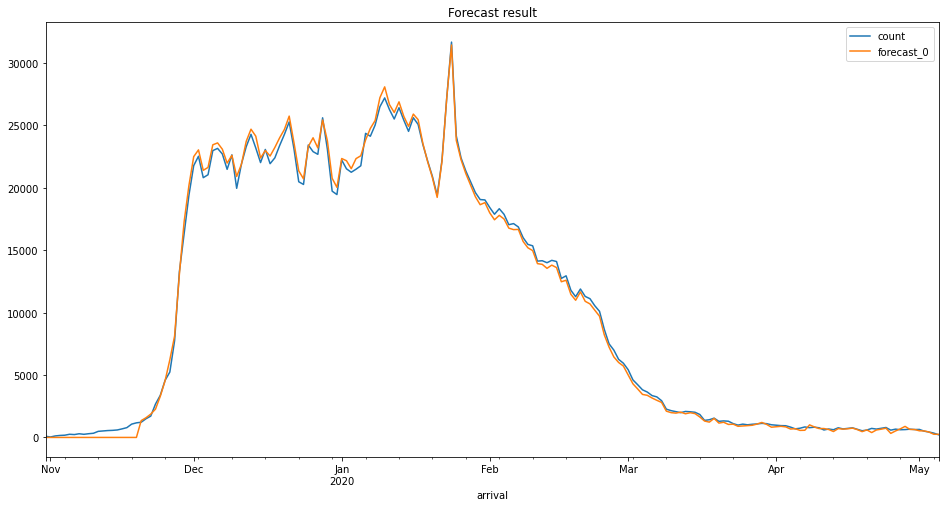

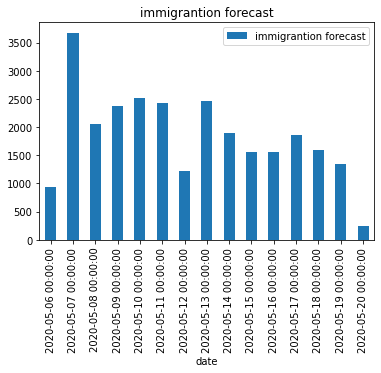

In [218]:
# window = 40, forecast=1 로, 하루 앞을 예측하고 output을 재귀적으로 입력하여 15일까지를 예측한다.
#이렇게 하기 위해서는 trainset에서 y값이 x값과 같아야 한다.

def recursive_forecast(model,test_x,recursion=15):
  predict = []
  for i in range(recursion):
    predit_y = model.predict(test_x)
    predict.append(predit_y[0][0])
    new_test_x = test_x.reshape(test_x.shape[1],test_x.shape[2])
    new_test_x = np.concatenate((new_test_x, predit_y), axis=0)[1:window+1,:]
    test_x = new_test_x.reshape(1,new_test_x.shape[0],new_test_x.shape[1])
  return np.asarray(predict).reshape(1,recursion)


window = 20
forecast=1
train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y_iso_cov_ns,window=window, forecast=forecast)
model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=200,trial=1)
plot_train_result(hist)
predit_y = model.predict(train_x)
predit_y,predit_y.shape
compare_with_org_y(org_y=ds_y,comp_y=predit_y,comp_index=[0],window=window, forecast=forecast)

predit_y = recursive_forecast(model,test_x)
display_result(predit_y,ds_y)

In [0]:
# LSTM
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(units=size*2, return_sequences=True, input_shape=(window, size)))
model.add(Dropout(0.02))

model.add(LSTM(units=size*2, return_sequences=True))
model.add(Dropout(0.02))

model.add(LSTM(units=size*2, return_sequences=True))
model.add(Dropout(0.02))

model.add(LSTM(units=size*2))
model.add(Dropout(0.02))

model.add(Dense(forecast_days))
model.add(Activation('linear'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae',r2])

print(model.summary())

model_json = model.to_json()
with open("combined_model.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()

print("save to combined_model.json")



In [0]:
ensemble = []
for i in range(1):
  model,hist = train_combined_model(i+1,epochs=20,verbose=0,metrics=['mae',r2])
  ensemble.append(model)
    
print("Wait! saving model...")    
file = open("ensemble.mdl", 'wb')
dill.dump(ensemble, file)
file.close()
        
print("Complete!!")

In [0]:

predit_y,ensemble_predit_y = ensemble_predict(train_x)
predit_y,predit_y.shape

In [0]:
compare_backdata(predit_y)